# Imporant pixels

You are given a pipeline that trains a fully convolutional autoencoder on the MNIST dataset. The model should train in under 2 minutes and give decent results (mean reconstruction loss <35).

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.


Training pipeline (DO NOT CHANGE THIS SECTION)

In [1]:
import typing
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
epochs = 5
batch_size = 250
learning_rate = 1e-2
log_interval = 40

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST('./data', train=True, transform=img_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MNIST('./data', train=False, transform=img_transform, download=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(
            1,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                32,
                7, 
                2, 
                0, 
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                3, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                8,
                5, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                8,
                1,
                4, 
                1, 
                0, 
                bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.size(0)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))



In [6]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1198.498000
Train Epoch: 1 [10000/60000 (17%)]	Loss: 197.166094
Train Epoch: 1 [20000/60000 (33%)]	Loss: 149.928250
Train Epoch: 1 [30000/60000 (50%)]	Loss: 126.353352
Train Epoch: 1 [40000/60000 (67%)]	Loss: 106.630578
Train Epoch: 1 [50000/60000 (83%)]	Loss: 90.728844

Test set: Average loss: 87.1732

Train Epoch: 2 [0/60000 (0%)]	Loss: 86.058312
Train Epoch: 2 [10000/60000 (17%)]	Loss: 81.385578
Train Epoch: 2 [20000/60000 (33%)]	Loss: 78.534719
Train Epoch: 2 [30000/60000 (50%)]	Loss: 72.245531
Train Epoch: 2 [40000/60000 (67%)]	Loss: 63.994840
Train Epoch: 2 [50000/60000 (83%)]	Loss: 69.853648

Test set: Average loss: 60.6926

Train Epoch: 3 [0/60000 (0%)]	Loss: 61.478727
Train Epoch: 3 [10000/60000 (17%)]	Loss: 56.770187
Train Epoch: 3 [20000/60000 (33%)]	Loss: 55.219625
Train Epoch: 3 [30000/60000 (50%)]	Loss: 53.723320
Train Epoch: 3 [40000/60000 (67%)]	Loss: 58.175203
Train Epoch: 3 [50000/60000 (83%)]	Loss: 48.759512

Test set: Average loss

# Important pixels

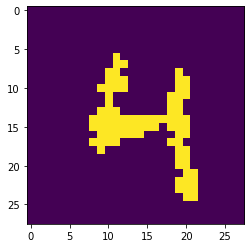

In [7]:
input_batch = next(iter(train_loader))[0][0,:].unsqueeze(0)
input_batch = input_batch.to(device)
plt.imshow(input_batch[0, :].cpu().detach().squeeze().numpy())

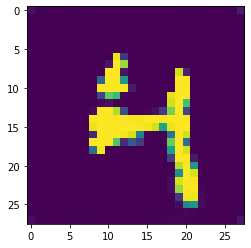

In [8]:
plt.imshow(model(input_batch)[0, :].cpu().detach().squeeze().numpy())

In [9]:
input_batch[0].shape

torch.Size([1, 28, 28])

In [13]:
def important_pixels(input_batch: torch.Tensor, model: torchvision.models.segmentation.fcn.FCN, device: torch.device, coordinates: typing.Tuple[int, int]) -> typing.Set[typing.Tuple[int,int]]: 
    model = model.to(device)
    input_batch = input_batch.to(device)
    output = model(input_batch)
    pixels = []
    ################################
    for i in range(input_batch.shape[2]):
      for j in range(input_batch.shape[3]):
        max_img = input_batch.clone()
        min_img = input_batch.clone()
        max_img[0][0][i][j] = input_batch.max()
        min_img[0][0][i][j] = input_batch.min()
        output_max = model(max_img)
        output_min = model(min_img)
        max_imp = abs(output_max[0][0][coordinates[0]][coordinates[1]]
                      - output[0][0][coordinates[0]][coordinates[1]])
        min_imp = abs(output_min[0][0][coordinates[0]][coordinates[1]]
                      - output[0][0][coordinates[0]][coordinates[1]])
        imp = max_imp + min_imp
        if imp != 0:
          pixels.append([i, j])
    ################################
    return pixels


In [14]:
checked_pixel = (0, 0)
pixels = important_pixels(input_batch, model, device, checked_pixel)

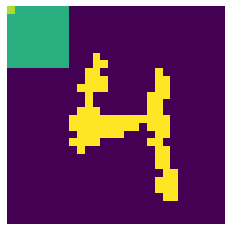

In [15]:
input_image_numpy = input_batch[0, :].cpu().detach().squeeze().numpy()

for pixel in pixels:
    input_image_numpy[pixel[0], pixel[1]] = 0.25

input_image_numpy[checked_pixel[0], checked_pixel[1]] = 0.75

plt.imshow(input_image_numpy)
plt.axis("off")
plt.show()